In [1]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C
import cntk.tests.test_utils
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
%matplotlib inline

## Refrences

https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians

https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

https://github.com/altosaar/variational-autoencoder/blob/master/vae.py

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


In [2]:

# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("E:\\", "Temp", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break

if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))


Data directory is E:\Temp\MNIST


In [75]:
input_dim = 784
encoding_dim = 32
output_dim = input_dim
# training config
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 64
num_sweeps_to_train_with = 20 if isFast else 100
num_samples_per_sweep = 60000
    


def decoder(input):
    intermediate = C.layers.Sequential([C.layers.Dense(input_dim//2, activation = C.relu), 
                               C.layers.Dense(input_dim, activation=C.sigmoid)])(input)
    return intermediate
    
def encoder(input):
    intermediate = C.layers.Sequential([C.layers.Dense(input_dim//2, activation = C.relu), 
                               C.layers.Dense(encoding_dim, activation=C.relu)])(input)
    
    mu = C.layers.Dense(encoding_dim, activation=None)(intermediate)
    sigma = C.layers.Dense(encoding_dim, activation=C.relu)(intermediate)

    
    return mu, sigma

In [105]:
network = {}
def create_network():
    
    input = C.input_variable(input_dim)
    label = C.input_variable(input_dim)
    network['input'] = input
    network['label'] = label

    # Create the model function
    mu, sigma = encoder(input/255.0)
    network['mu'] = mu
    network['sigma'] = sigma
    sample = C.random.normal_like(mu, mean=0, scale=1)
    sample = mu + sigma * sample       
    model = decoder(sample)    
    network['decoding'] = model
    return network




def train_and_test(reader_train, reader_test):

    ###############################################
    # Training the model
    ###############################################

    # Instantiate the input and the label variables
    network = create_network()    
    
    # The labels for this network is same as the input MNIST image.
    # Note: Inside the model we are scaling the input to 0-1 range
    # Hence we rescale the label to the same range
    # We show how one can use their custom loss function
    # we will use simple reconstruction error - squared diff 
    label = network['label']
    input = network['input']
    model = network['decoding']
    mu = network['mu']
    sigma = network['sigma']
    target = network['label']/255.0
    loss = C.losses.squared_error(target,model)
    
    # the above loss doesn't restrict the encoding domain
    # in ideal scenario, to generate fake images we want to feed a
    # noise to decoder and get real-like images
    # inorder to do this, we need encoding domain to be known. Usually we restrict
    # the encoding to be N(0,1), we can sample noise from N(0,1) get real-like images
    # we want encoder to predict mean and sd for each element and sample from that for decoding
    log_stddev = C.log(sigma)
    klloss = - 0.5 * (1 + log_stddev - C.square(mu) - C.square(C.exp(log_stddev)))
    loss = loss +  klloss

    
    label_error  = C.classification_error(model, target)

    
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size


    # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)

    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.9126265014311797, minibatch_size)

    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(model.parameters,
                         lr=lr_schedule, momentum=momentum_schedule)

    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(model, (loss, label_error), learner, progress_printer)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : reader_train.streams.features,
        label  : reader_train.streams.features
    }

    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = reader_train.next_minibatch(minibatch_size, input_map = input_map)

        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples

    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))

    #############################################################################
    # Testing the model
    # Note: we use a test file reader to read data different from a training data
    #############################################################################

    # Test data for trained model
    test_minibatch_size = 32
    num_samples = 10000
    num_minibatches_to_test = num_samples / test_minibatch_size
    test_result = 0.0

    # Test error metric calculation
    metric_numer    = 0
    metric_denom    = 0

    test_input_map = {
        input  : reader_test.streams.features,
        label  : reader_test.streams.features
    }

    for i in range(0, int(num_minibatches_to_test)):

        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions
        # with one pixel per dimension that we will encode / decode with the
        # trained model.
        data = reader_test.next_minibatch(test_minibatch_size,
                                       input_map = test_input_map)

        # Specify the mapping of input variables in the model to actual
        # minibatch data to be tested with
        eval_error = trainer.test_minibatch(data)

        # minibatch data to be trained with
        metric_numer += np.abs(eval_error * test_minibatch_size)
        metric_denom += test_minibatch_size

    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom)
    print("Average test error: {0:0.2f}%".format(test_error))
    
    return model, train_error, test_error

In [106]:
isFast = True
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels_viz = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)



num_label_classes = 10
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)
model, simple_ae_train_error, simple_ae_test_error = train_and_test(reader_train,
                                                                    reader_test)


C:\Users\serajago.FAREAST\AppData\Local\Continuum\Anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per 1 samples: 3e-05
 6.41e+03   6.41e+03       0.88       0.88            64
 6.38e+03   6.37e+03      0.896      0.903           192
 6.36e+03   6.34e+03      0.913      0.927           448
 6.26e+03   6.18e+03      0.884      0.858           960
 5.56e+03    4.9e+03      0.819      0.757          1984
 4.03e+03   2.54e+03      0.664      0.515          4032
 3.07e+03   2.13e+03      0.563      0.462          8128
 2.51e+03   1.96e+03      0.446      0.331         16320
 2.09e+03   1.67e+03      0.322      0.199         32704
 1.77e+03   1.45e+03       0.23      0.138         65472
 1.54e+03   1.31e+03      0.159     0.0885        131008
 1.38e+03   1.23e+03      0.108     0.0567        262080
 1.27e+03   1.15e+03     0.0757     0.0434        524224
 1.13e+03        998     0.0529     0.0302       1048512

Original image statistics:
Max: 255.00, Median: 0.00, Mean: 12.59, Min: 0.00
Decoded image statistics:
Max: 246.16, Median: 0.13, Mean: 12.88, Min: 0.00


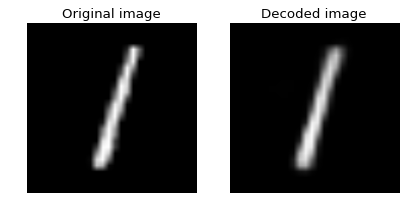

In [94]:
# Read some data to run the eval
num_label_classes = 10
reader_eval = create_reader(test_file, False, input_dim, num_label_classes)

eval_minibatch_size = 50
eval_input_map = { input  : reader_eval.streams.features }

eval_data = reader_eval.next_minibatch(eval_minibatch_size,
                                  input_map = eval_input_map)

img_data = eval_data[input].asarray()

# Select a random image
np.random.seed()
idx = np.random.choice(eval_minibatch_size)

orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)[0]*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img)))

# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


# Define a helper function to plot a pair of images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(text1)
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(text2)
    axes[1].axis("off")
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

In [103]:
# Select a random image
np.random.seed()
idx = np.random.choice(eval_minibatch_size)
network['sig'].eval(img_data[idx,:,:])

array([[ 0.        ,  0.        ,  0.66685939,  0.        ,  0.41162193,
         0.38101435,  0.7649737 ,  1.30843389,  0.        ,  0.46245933,
         0.        ,  0.        ,  1.27721357,  0.33044845,  1.43980563,
         0.88219088,  0.        ,  0.        ,  0.87134933,  0.2124386 ,
         0.21936195,  0.        ,  0.58183432,  0.53038526,  1.92033005,
         0.97121269,  0.28579801,  0.36218014,  1.05822837,  0.38342437,
         0.        ,  0.51377368]], dtype=float32)

In [74]:
network['decoder'].inputs

(Parameter('W', [], [392 x 784]),
 Parameter('b', [], [784]),
 Parameter('W', [], [32 x 392]),
 Parameter('b', [], [392]),
 Parameter('W', [], [32 x 32]),
 Parameter('b', [], [32]),
 Parameter('W', [], [392 x 32]),
 Parameter('b', [], [32]),
 Parameter('W', [], [784 x 392]),
 Parameter('b', [], [392]),
 Input('Input3344', [#], [784]),
 Constant('Constant3346', [], []),
 Parameter('W', [], [32 x 32]),
 Parameter('b', [], [32]))